In [1]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

import matplotlib.pyplot as plt

from tensorflow.keras.layers import concatenate


In [2]:
tf.enable_eager_execution()


In [3]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [4]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [5]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [6]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      # h = h +self.res2(self.res1(h)) #
      h = concatenate([h , self.res2(self.res1(h))]) # concatenate instead of add 
    return h

In [7]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)
x_train=(x_train/255.0).astype('float32')
x_test = (x_test/255.0).astype('float32')
train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

170500096/170498071 [==============================] - 8s 0us/step


In [9]:
# cutout for tensorflow 
# other customization parameters like 
# separate min/max_width, min/max_height,  etc could be added 
#yet to make checks to exit gracefully for valid params e.g cutout size param > img size 

def cutout(img,prob=50,size=16,min_size=5,use_fixed_size=False):
  return tf.cond(tf.random.uniform([], 0, 100) > prob, lambda: img , lambda: get_cutout(img,prob,size,min_size,use_fixed_size))



def get_cutout(img,prob=50,size=16,min_size=5,use_fixed_size=False):
  
  
  height = tf.shape(img)[0]
  width = tf.shape(img)[1]
  channel = tf.shape(img)[2]
  
  #subtract the mean of train dataset from the image , we will add this back later 
  mean = tf.constant(train_mean, dtype=tf.float32) # (3)
  mean = tf.reshape(mean, [1, 1, 3])
  img_m = img - mean

  #get cutout size and offsets 
  if (use_fixed_size==True):
    s=size
  else:  
    s=tf.random.uniform([], min_size, size, tf.int32) # use a cutout size between 5 and size 

  x1 = tf.random.uniform([], 0, height+1 - s, tf.int32) # get the x offset from top left
  y1 = tf.random.uniform([], 0, width+1 - s, tf.int32) # get the y offset from top left 

  # create the cutout slice and the mask 
  img1 = tf.ones_like(img)  
  
  cut_slice = tf.slice(
  img1,
  [x1, y1, 0],
  [s, s, 3]
     )
  #create mask similar in shape to input image with cutout area having ones and rest of the area padded with zeros 
  mask = tf.image.pad_to_bounding_box(
    [cut_slice],
    x1,
    y1,
    height,
    width
  )
  
  #invert the zeros and ones 
  mask = tf.ones_like(mask ) - mask
  
  #inv_mask = tf.where( tf.equal( -1.0, mask ), 1.0 * tf.ones_like( mask ), mask ) # not needed
  
  #apply cutout on the image , get back a shape of [1,32,32,3] instead of [32,32,3]
  tmp_img = tf.multiply(img_m,mask)

  #add back the mean that we subtracted 
  cut_img = tmp_img[0] + mean
  
 # commented out initial numpy based implementation 
  '''
  print('cut out using numpy  ')

  ## this worked too , but when applied to tensors , the same cutout region got used for all images ... need to verify again

  mask = np.ones((32, 32,3), np.float32)
  


  
  y = np.random.randint(32)
  x = np.random.randint(32)
  
  length = np.random.randint(1, 17) 

  y1 = np.clip(y - length // 2, 0, 32)
  y2 = np.clip(y + length // 2, 0, 32)
  x1 = np.clip(x - length // 2, 0, 32)
  x2 = np.clip(x + length // 2, 0, 32)
  

  for i in range(3): 
    mask[y1: y2, x1: x2,i] = 0.
  
  tmp_img3=tf.multiply(img,mask) 
  '''
 
    
  return cut_img

In [ ]:
def data_aug1(x, y):
  x1=tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3]))
   
  return (cutout(x1,prob=60,size=16,use_fixed_size=True),x1,y)

W0816 22:11:20.434536 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image 1 with cutout



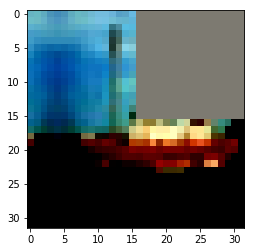

W0816 22:11:20.606976 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image 1 without cutout



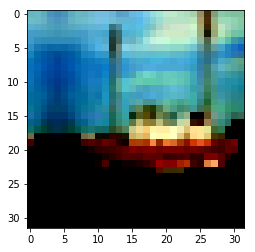



image 2 with cutout



W0816 22:11:20.897161 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


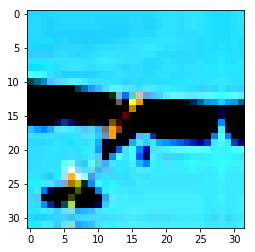

W0816 22:11:21.052835 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image 2 without cutout



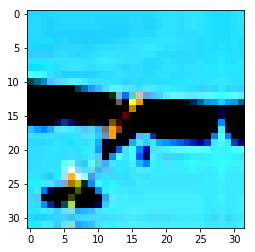

W0816 22:11:21.208862 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




image 3 with cutout



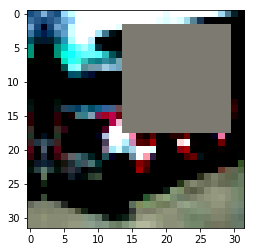

W0816 22:11:21.377938 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image 3 without cutout



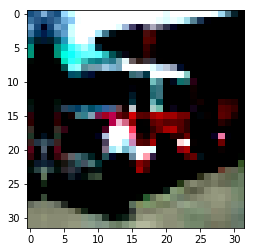

W0816 22:11:21.532180 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




image 4 with cutout



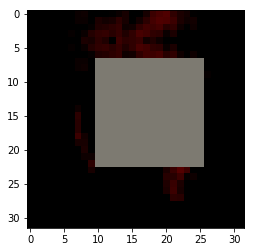

W0816 22:11:21.694546 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image 4 without cutout



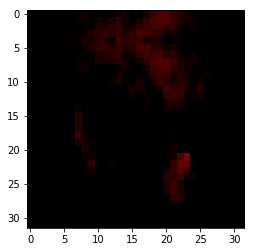

W0816 22:11:21.851145 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




image 5 with cutout



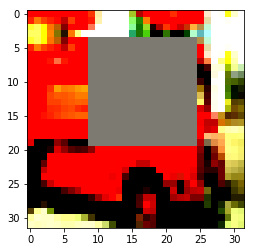

W0816 22:11:22.009886 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image 5 without cutout



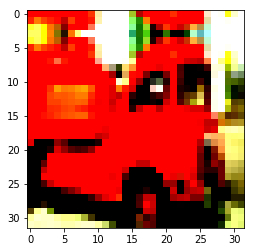

W0816 22:11:22.172723 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




image 6 with cutout



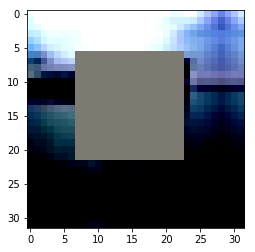


image 6 without cutout



W0816 22:11:22.364896 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


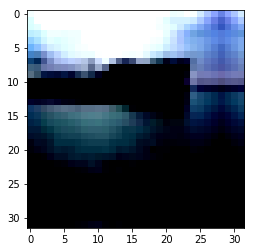

W0816 22:11:22.521805 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




image 7 with cutout



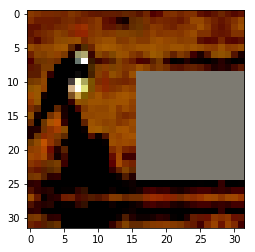

W0816 22:11:22.689674 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image 7 without cutout



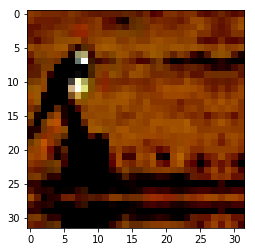

W0816 22:11:22.857742 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




image 8 with cutout



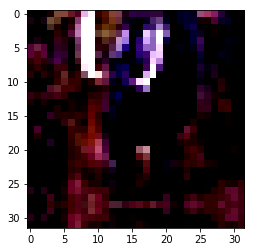

W0816 22:11:23.021392 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image 8 without cutout



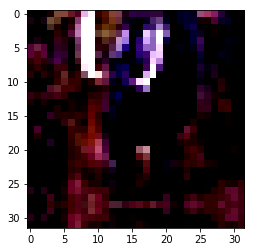

W0816 22:11:23.184623 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




image 9 with cutout



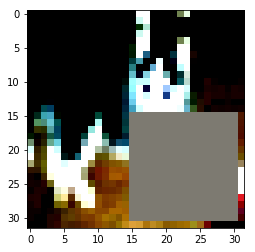

W0816 22:11:23.354506 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image 9 without cutout



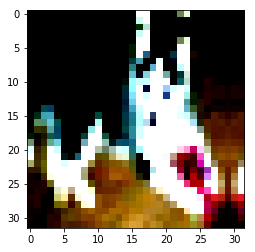

W0816 22:11:23.524283 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).




image 10 with cutout



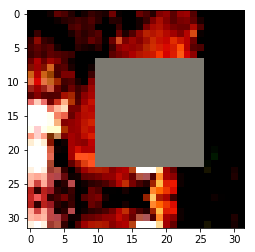

W0816 22:11:23.684234 139988684470144 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



image 10 without cutout



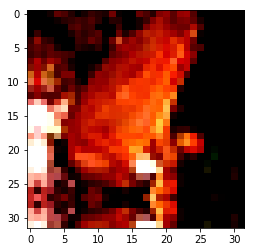

In [11]:
train_set1 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug1).shuffle(len_train).batch(10).prefetch(1)

im,=train_set1.take(1)

image,image1, label = im[0], im[1],im[2]
images=image.numpy().astype(np.float32)
images1=image1.numpy().astype(np.float32)

for i in range(len(images)):
  print("\n======\nimage "+str(i+1)+" with cutout\n==========\n")
  img1=images[i]
  plt.imshow(img1)
  plt.show()
  print("\n======\nimage "+str(i+1)+" without cutout\n==========\n")
  img2=images1[i]
  plt.imshow(img2)
  plt.show()
  print("\n=============")


In [11]:
def data_aug2(x, y):
  x1=tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3]))
   
  return (cutout(x1,prob=60,size=8,use_fixed_size=True),y)

In [ ]:
#def data_aug3(x, y):
  #if (epoch%3==0):
    #return (cutout(tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])),prob=50,size=12,min_size=8,use_fixed_size=False), y)
  #else:
    #return (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)
  #x1=tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3]))
   
  #return (cutout(x1,prob=60,size=8,use_fixed_size=True),y)

In [ ]:
#train_set2 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug2).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

#im,=train_set2.take(1)

#image,label = im[0],im[1]
#images=image.numpy().astype(np.float32)
#images1=image1.numpy().astype(np.float32)

#for i in range(len(images)):
  #print("\n======\nimage "+str(i+1)+" with cutout\n==========\n")
  #img1=images[i]
  #plt.imshow(img1)
  plt.show()
  #print("\n======\nimage "+str(i+1)+" without cutout\n==========\n")
  #img2=images1[i]
  #plt.imshow(img2)
  #plt.show()
  #print("\n=============")


In [12]:
train_array = []
for i in range(24):
  train_set3 = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug2).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)
  train_array.append(train_set3)
#im,=train_set2.take(1)

print(len(train_array))

Instructions for updating:
Colocations handled automatically by placer.
24


In [13]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE 
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
#data_aug1 = lambda x,y : 
#data_aug2 = lambda x,y : 
def data_aug(x, y):
  if (epoch%3==0):
    return (cutout(tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])),prob=50,size=12,min_size=8,use_fixed_size=False), y)
  else:
    return (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)  
  

In [14]:
t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  #train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)
  train_set=train_array[epoch]
  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
    
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

epoch: 1 lr: 0.08 train loss: 1.6431305871582031 train acc: 0.40654 val loss: 1.421312255859375 val acc: 0.5272 time: 28.081334352493286



epoch: 2 lr: 0.16 train loss: 0.9059501739501953 train acc: 0.67788 val loss: 0.9228261627197266 val acc: 0.6887 time: 50.61204195022583



epoch: 3 lr: 0.24 train loss: 0.6895894674682618 train acc: 0.76046 val loss: 0.7652175216674805 val acc: 0.7364 time: 73.1292712688446



epoch: 4 lr: 0.32 train loss: 0.5853001513671875 train acc: 0.79776 val loss: 0.6698028656005859 val acc: 0.7788 time: 95.61858916282654



epoch: 5 lr: 0.4 train loss: 0.5276124829101563 train acc: 0.81666 val loss: 0.6253013626098632 val acc: 0.7899 time: 118.0705955028534



epoch: 6 lr: 0.37894736842105264 train loss: 0.4387606401062012 train acc: 0.84768 val loss: 0.5273974319458008 val acc: 0.8227 time: 140.62073683738708



epoch: 7 lr: 0.35789473684210527 train loss: 0.3750535354614258 train acc: 0.86904 val loss: 0.46498593139648436 val acc: 0.8439 time: 163.19974899291992



epoch: 8 lr: 0.33684210526315794 train loss: 0.32810360870361327 train acc: 0.88536 val loss: 0.4071087944030762 val acc: 0.8628 time: 185.7776563167572



epoch: 9 lr: 0.31578947368421056 train loss: 0.2865937414550781 train acc: 0.90062 val loss: 0.33262473602294923 val acc: 0.8903 time: 208.36528706550598



epoch: 10 lr: 0.2947368421052632 train loss: 0.2526363284301758 train acc: 0.91296 val loss: 0.39126452865600586 val acc: 0.8771 time: 230.8959813117981



epoch: 11 lr: 0.2736842105263158 train loss: 0.23026276351928712 train acc: 0.9195 val loss: 0.3263803298950195 val acc: 0.8961 time: 253.46743535995483



epoch: 12 lr: 0.25263157894736843 train loss: 0.2045718685913086 train acc: 0.92936 val loss: 0.3597789169311523 val acc: 0.8854 time: 275.97407150268555



epoch: 13 lr: 0.23157894736842108 train loss: 0.18004945587158203 train acc: 0.93644 val loss: 0.29236333236694334 val acc: 0.9033 time: 298.53295040130615



epoch: 14 lr: 0.2105263157894737 train loss: 0.16384732452392578 train acc: 0.9429 val loss: 0.30606320037841794 val acc: 0.9032 time: 320.97609782218933



epoch: 15 lr: 0.18947368421052635 train loss: 0.14829802780151366 train acc: 0.9488 val loss: 0.29573218460083006 val acc: 0.9023 time: 343.59819054603577



epoch: 16 lr: 0.16842105263157897 train loss: 0.13238736709594726 train acc: 0.95442 val loss: 0.30141783447265624 val acc: 0.904 time: 366.0944366455078



epoch: 17 lr: 0.1473684210526316 train loss: 0.11696065605163575 train acc: 0.9596 val loss: 0.24928178939819337 val acc: 0.9227 time: 388.7920951843262



epoch: 18 lr: 0.12631578947368421 train loss: 0.10136880493164062 train acc: 0.9659 val loss: 0.253777014541626 val acc: 0.924 time: 411.4211151599884



epoch: 19 lr: 0.10526315789473689 train loss: 0.09069959121704102 train acc: 0.9689 val loss: 0.25780390663146974 val acc: 0.9208 time: 434.1484456062317



epoch: 20 lr: 0.08421052631578951 train loss: 0.08126258228302002 train acc: 0.9725 val loss: 0.24142824058532714 val acc: 0.9258 time: 456.7936451435089



epoch: 21 lr: 0.06315789473684214 train loss: 0.07000046243667603 train acc: 0.97734 val loss: 0.23540857849121094 val acc: 0.9291 time: 479.4769184589386



epoch: 22 lr: 0.04210526315789476 train loss: 0.06218550386428833 train acc: 0.97946 val loss: 0.22728731689453124 val acc: 0.9298 time: 502.0882227420807



epoch: 23 lr: 0.02105263157894738 train loss: 0.05586049003601074 train acc: 0.98206 val loss: 0.22081171340942382 val acc: 0.9351 time: 524.5590586662292



epoch: 24 lr: 0.0 train loss: 0.051336620712280276 train acc: 0.98448 val loss: 0.21836883201599122 val acc: 0.9347 time: 547.0911009311676
